## Cartpole Environment Reinforcement Learning

We train an agent to solve OpenAI Gym's Cartpole-v0 environment. The implementation is in the most recent version of the PyTorch frameworkfor building deep learning models.

In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [3]:
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()

if is_ipython:
    from IPython import display

plt.ion()

### Watch a Random Agent

It is useful to see how well the agent performs, before training train the agent. We can run the code cell below to watch how well the agent does, if it just pushes the cart randomly at each timestep. We can think of it as flipping a fair coin when deciding whether to push the cart to the left or to the right.

We run the code cell multiple times, to check the score for different episodes (or game rounds). It likely won't get a score above 30, and this is to be expected! Later we'll train the agent to consistently get a score larger than 195!

Score:  20


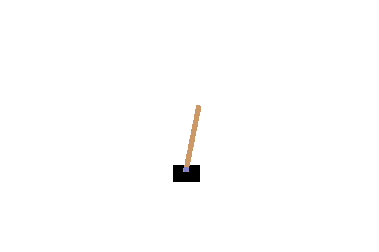

In [5]:
env = gym.make('CartPole-v0')

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))

for t in range(1000):

    action = env.action_space.sample()
    img.set_data(env.render(mode='rgb_array')) 

    plt.axis('off')

    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    state, reward, done, _ = env.step(action)

    if done:
        print('Score: ', t+1)
        break
        
env.close()

### Define the Architecture of the Policy

We will define a neural network that encodes the agent's stochastic policy.

CartPole environment details:

- The agent has two possible actions: it can either push the cart to the left or to the right.
- The state at each timestep always has four numbers, corresponding to the position and velocity of the cart, along with the pole angle and velocity.
- The network that you will define takes the environment state as input. It returns as output the probability that the agent should select each possible action.

For example, when the agent observes a new state, it passes the state as input to the network. The network returns two numbers, corresponding to the probability that the agent will select each action. So, for instance, if the network returns [0.9, 0.1], the agent pushes the car to the left with 90% probability, and otherwise pushes the car to the right. Then the agent samples from the action space using these probabilities - say it ends up selecting the action that pushes the cart to the left. After selecting this action, it sends the action to the environment and receives a reward and next state. This next state is then fed as input to the network, and so on.

When we initialize the neural network, all of the weights are random. Our agent's goal then will be to figure out the appropriate weights in the neural network, so that for each state, the network always outputs probabilities that encode a good game-playing strategy, and help the agent get a high score!

In [6]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        """Neural network that encodes the policy.
        
        Params
        ======
            s_size (int): dimension of each state (also size of input layer)
            h_size (int): size of hidden layer
            a_size (int): number of potential actions (also size of output layer)
        """
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        
        return action.item(), m.log_prob(action)

observation space: Box(4,)
action space: Discrete(2)


### Train the Agent with Reinforcement Learning

We'll use the reinforcement algorithm, also known as Monte Carlo Policy Gradients, to guide the agent to train the weights of the neural network, while it's playing the game.

For now, run the training on the network. The OpenAI Gym considers the environment as "solved", if the average score over 100 episodes is at least 195.0.

In [7]:
env.seed(0)

policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=1000, max_t=200, gamma=1.0, print_every=100):
    """PyTorch implementation of the REINFORCE algorithm.
        
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
    """
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
    
scores = reinforce()

Episode 100	Average Score: 34.47
Episode 200	Average Score: 66.26
Episode 300	Average Score: 87.82
Episode 400	Average Score: 72.83
Episode 500	Average Score: 172.00
Episode 600	Average Score: 160.65
Episode 700	Average Score: 167.15
Environment solved in 691 episodes!	Average Score: 196.69


In [ ]:
### Plot the Scores

Run the code cell below to plot the scores that were received by the agent.

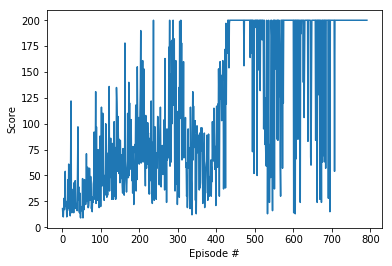

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Watch a Smart Agent

Finally, we can watch our smart agent! Doesn't it do much better than the random agent?

Score:  200


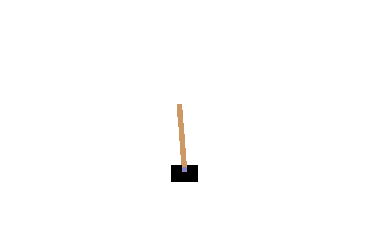

In [9]:
env = gym.make('CartPole-v0')

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))

for t in range(1000):
    action, _ = policy.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        print('Score: ', t+1)
        break
        
env.close()

### Conclusion

We are now in the position of trying to train our agent using much more advanced reinforcement learning methods.